<a href="https://colab.research.google.com/github/ranaamr22/ML-and-Deep-Learning/blob/main/trails%20in%20training%20template.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%pwd

'/content'

In [ ]:
%cd '/content/drive/MyDrive/keypoint_regression/keypoint_regression'
%pwd
# !unzip keypoint_regression.zip
# %cd 'keypoint_regression'
# !unzip data.zip

/content/drive/MyDrive/keypoint_regression/keypoint_regression


'/content/drive/MyDrive/keypoint_regression/keypoint_regression'

# Problem Statement:

The objective of this competition is to develop a keypoint regression model capable of predicting the keypoints of a cone in an image. To achieve this goal, participants will be provided with a dataset containing 1054 images of cones and their corresponding keypoint positions (x,y). The challenge involves building a model that can accurately predict the keypoints of cones in unseen images.

### Dataset:

The dataset consists of 1000 images of cones and their corresponding keypoint positions. Each image can be resized to 80x80 pixels, and the dataset preparation class has already been provided to participants. Additionally, data augmentation techniques are available for use to improve the generalization of the model. The keypoint positions are represented as 16-element vectors for each image.

### Model:

Participants are free to use any approach or model architecture to prepare their model. However, it should be capable of predicting the keypoint positions accurately. The models will be evaluated based on the following criteria:

    1) MSELoss: The model should have a low mean squared error (MSE) when predicting the keypoint positions. The lower the MSE, the better the model.

    2) Visual Display: The model's output should be visually appealing, accurately displaying the predicted keypoints on the cones. A good visual display of the output keypoints will indicate the quality of the model.

### Judging Criteria:

The models submitted by participants will be evaluated based on the following criteria:

    1) MSELoss: The models with lower MSE will be awarded higher scores. The MSE will be calculated based on the predicted keypoint positions of the cones.

    2) Visual Display: The models will be evaluated based on the visual display of the predicted keypoints on the cones. The models with better visual displays will be awarded higher scores.

    3) Inference Time: The inference time of each model will be measured based on 100 iterations. The models with shorter inference times will be awarded higher scores.

The model with the highest score based on the above criteria will be declared the winner of the competition.
The score will be evaluated based on the entire dataset including examples that are NOT included in the provided training data to measure the model's ability to generalize.
### Examples:
keypoint_regression/notebooks/Training.ipynb

### NOTE!!
You do not require the complete code base, as the other files are only included for reference purposes. These files can help you understand the overall pipeline bigger picture.

In [ ]:
# !unzip /content/keypoint_regression/data.zip

In [ ]:
%pwd

'/content/drive/MyDrive/keypoint_regression/keypoint_regression'

In [ ]:
import sys
import os

sys.path.append("..")

import matplotlib.pyplot as plt

import torch

from torch.utils.data import DataLoader
from torch.utils.data.dataset import random_split

from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.nn import Module, MSELoss, L1Loss

import torchvision.transforms as transforms

from dataset import  KeypointDataset

from model import KeypointNet

from trainer import TrainingParameters, train

# from utils import *

In [ ]:
imgsPath = "/content/drive/MyDrive/keypoint_regression/keypoint_regression/data/imgs"
jsonPath = "/content/drive/MyDrive/keypoint_regression/keypoint_regression/data/json"

def normalize_dataset(dataset):
    # Calculate mean and std deviation
    mean = torch.zeros(3)
    std = torch.zeros(3)
    for img, _ in dataset:
        img = img.expand(3, -1, -1)  # add extra dimension for RGB channel
        mean += torch.mean(img, dim=(1, 2))
        std += torch.std(img, dim=(1, 2))
    mean /= len(dataset)
    std /= len(dataset)
    
    # Create normalization transform
    normalize = transforms.Normalize(mean=mean, std=std)
    
    # Apply transform to dataset
    transformed_dataset = []
    for img, target in dataset:
        img = img.expand(3, -1, -1)  # add extra dimension for RGB channel
        img = normalize(img)
        transformed_dataset.append((img, target))
    
    return transformed_dataset

dataset =KeypointDataset(jsonPath, imgsPath)
# normalized_dataset = normalize_dataset(dataset)

In [ ]:
# preparing dataloaders
TRAIN_SIZE = int(0.7*len(dataset))
VALID_SIZE = int(0.2*len(dataset))
TEST_SIZE = len(dataset) - TRAIN_SIZE - VALID_SIZE
BATCH_SIZE = 128

# random split the data
trainDataset, valDataset, testDataset = random_split(dataset, [TRAIN_SIZE, VALID_SIZE, TEST_SIZE])

# creating dataloaders
trainLoader = DataLoader(trainDataset, batch_size=BATCH_SIZE)
validLoader = DataLoader(valDataset, batch_size=BATCH_SIZE)
testLoader = DataLoader(testDataset, batch_size=BATCH_SIZE)

# sanity check
print('='*30)
print("Train dataset", len(trainDataset))
print("Valid dataset", len(valDataset))
print("Test dataset", len(testDataset))

Train dataset 737
Valid dataset 210
Test dataset 107


### Example of how to show image from batch

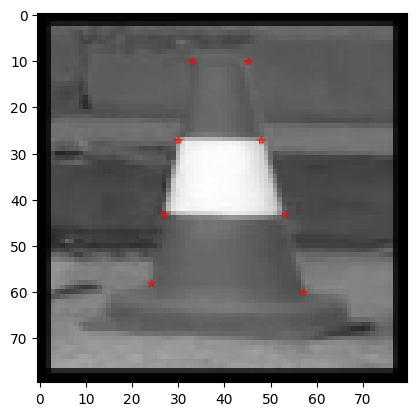

In [ ]:
# sanity check
import numpy as np
import matplotlib.pyplot as plt

imgs, labels = next(iter(testLoader))
i = 0
bs, _, height, width = imgs.shape
kps = labels[i].cpu().detach().numpy()

kps = kps.reshape(-1,2)
kps[:,0] = kps[:,0]*width
kps[:,1] = kps[:,1]*height
kps = kps.astype(int)

img = imgs[i].cpu().detach().permute(1,2,0).squeeze(2).numpy().astype(np.float32).copy()
for point1 in kps:
    plt.plot(*point1, marker='*', color='red', alpha=0.5)

plt.imshow(img, cmap='gray')
plt.show()

In [ ]:
print(imgs.shape)
print(labels[0])

torch.Size([107, 1, 80, 80])
tensor([24.3693, 58.6080, 27.3466, 43.7216, 30.3238, 27.3466, 33.3011, 10.9715,
        45.2102, 10.2272, 48.9318, 27.3466, 53.3977, 43.7216, 57.1193, 60.8409])


In [ ]:
print(imgs.reshape(107,80,80).shape)
print(labels[0])

torch.Size([107, 80, 80])
tensor([24.3693, 58.6080, 27.3466, 43.7216, 30.3238, 27.3466, 33.3011, 10.9715,
        45.2102, 10.2272, 48.9318, 27.3466, 53.3977, 43.7216, 57.1193, 60.8409])


In [ ]:
kps = labels[0].cpu().detach().numpy()

print(kps)

[24.369297 58.60798  27.346571 43.721596 30.323849 27.346573 33.30113
 10.97155  45.21023  10.227231 48.93183  27.346573 53.397747 43.721596
 57.11934  60.840935]


In [ ]:
print(kps)

[[24 58]
 [27 43]
 [30 27]
 [33 10]
 [45 10]
 [48 27]
 [53 43]
 [57 60]]


In [ ]:
labels2=labels.reshape(107,8,2)
print(labels2)

tensor([[[24.3693, 58.6080],
         [27.3466, 43.7216],
         [30.3238, 27.3466],
         ...,
         [48.9318, 27.3466],
         [53.3977, 43.7216],
         [57.1193, 60.8409]],

        [[ 0.6112,  0.7716],
         [ 0.6554,  0.6328],
         [ 0.6869,  0.4814],
         ...,
         [ 0.8446,  0.4877],
         [ 0.8825,  0.6391],
         [ 0.9140,  0.7842]],

        [[ 0.4017,  0.8420],
         [ 0.4321,  0.7492],
         [ 0.4415,  0.6481],
         ...,
         [ 0.5688,  0.6179],
         [ 0.6003,  0.7259],
         [ 0.6407,  0.8231]],

        ...,

        [[ 0.3800,  0.6600],
         [ 0.4100,  0.5500],
         [ 0.4200,  0.4100],
         ...,
         [ 0.5600,  0.4000],
         [ 0.5600,  0.5400],
         [ 0.5600,  0.6700]],

        [[ 0.3651,  0.6510],
         [ 0.4011,  0.5380],
         [ 0.4033,  0.4034],
         ...,
         [ 0.5509,  0.3781],
         [ 0.5880,  0.5102],
         [ 0.6313,  0.6260]],

        [[ 0.1753,  0.7384],
       

In [ ]:
kps = kps.reshape(-1,2)
print(kps)


[[24.369297 58.60798 ]
 [27.346571 43.721596]
 [30.323849 27.346573]
 [33.30113  10.97155 ]
 [45.21023  10.227231]
 [48.93183  27.346573]
 [53.397747 43.721596]
 [57.11934  60.840935]]


In [ ]:
imgs,labels=next(iter(trainLoader))
no_of_imgs=len(imgs)
imgs=imgs.reshape(no_of_imgs,80,80)
labels=labels.reshape(no_of_imgs,8,2)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


## Modelling 

In [ ]:
class KeypointNet(Module):
    def __init__(self, inputChannels, outKeypoints):
        super().__init__()
        self.inputChannels = inputChannels
        self.outKeypoints = outKeypoints
        # @TODO Define your model
        
    #@TODO write the forward function
    def forward(self, x):
        pass

In [ ]:
from typing import Union, Tuple
import torch
from torch import nn
import datetime
class ResBlock(nn.Module):
    """Represents Residual blocks from resenet paper:
    Deep Residual Learning for Image Recognition  https://arxiv.org/abs/1512.03385
    """

    def __init__(self, dims: int, kernelSize: Union[int, Tuple[int]] = 3):
        """constructor

        Parameters:
        -----------
        dims:(int, Tuple)
            input and output dimension
        kernelSize: Union[int, Tuple[int]] default=3
            convolution kernel size
        """
        super().__init__()
        if isinstance(kernelSize, Tuple):
            padding = (int((kernelSize[0] - 1) / 2), int((kernelSize[1] - 1) / 2))
        else:
            padding = int((kernelSize - 1) / 2)

        self.model = nn.Sequential(
            nn.Conv2d(in_channels=dims, out_channels=dims, kernel_size=kernelSize, padding=padding),
            nn.ReLU(),
            # nn.BatchNorm2d(dims),
            nn.Conv2d(in_channels=dims, out_channels=dims, kernel_size=kernelSize, padding=padding),
            nn.ReLU(),
            # nn.BatchNorm2d(dims),
        )

    def forward(self, featureVector: torch.Tensor) -> torch.Tensor:
        """performs forward propagation

        Parameters:
        -----------
        featureVector: torch.Tensor
            input feature vector for resblock+

        Returns:
        --------
        torch.Tensor
            represents the features vector output
            of the resblock
        """
        out = self.model(featureVector)
        return out + featureVector


def miniTest():
    """tests little tests to the module"""
    model = KeypointNet(1, 8)
    model = model.cuda()

    total = 0
    ITERATIONS = 100
    model.eval()

    for _ in range(ITERATIONS):

        imagesBatch = torch.randn(80, 1, 80, 80)  # pylint: disable=no-member
        time1 = datetime.datetime.now()

        # put images on cuda
        imagesBatch = imagesBatch.cuda()
        y = model(imagesBatch)

        # computing time difference and calculating average execution time
        time2 = datetime.datetime.now()
        total += (time2 - time1).microseconds * 1e-3

    print(total / ITERATIONS, "ms")


if __name__ == "__main__":
    miniTest()

62.79606 ms


In [ ]:

class KeypointNet(nn.Module):
    """keypoint regression class"""

    def __init__(self, inputChannels, outKeypoints: int = 8):
        """constructor

        Parameters:
        -----------
            outKeypoints: Default=8.
        """
        super().__init__()
        self.outKeypoints = outKeypoints
        self.convPart = nn.Sequential(
            nn.Conv2d(inputChannels, 64, kernel_size=(7, 7), stride=3, dilation=(2, 2)),
            #nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            ResBlock(dims=64, kernelSize=(3, 3)),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=1),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            ResBlock(dims=128, kernelSize=(3, 3)),
            nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            #nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            ResBlock(dims=256, kernelSize=(3, 3)),
            nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1),
            #nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(512),
            ResBlock(dims=512, kernelSize=(3, 3)),
        )

        self.fcNet = nn.Linear(512 * 23 * 23, self.outKeypoints * 2)

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        """performs forward propagation

        Parameters:
        -----------
        img: torch.Tensor
            input bound image for the model to extract
            features from. The image input size is expected to be (100,50)

        Returns:
        --------
        torch.Tensor
            shape = (batch_size, self.outKeypoints) representing the keypoints
                of the cone in the input image relative to the image frame
        """
        # convolutional part
        img = self.convPart(img)
        # fc part
        img = img.view(img.size(0), -1)
        img = self.fcNet(img)

        return img

In [ ]:

class KeypointNet(nn.Module):
    """keypoint regression class"""

    def __init__(self, inputChannels, outKeypoints: int = 8):
        """constructor

        Parameters:
        -----------
            outKeypoints: Default=8.
        """
        super().__init__()
        self.outKeypoints = outKeypoints
        self.convPart = nn.Sequential(
            nn.Conv2d(inputChannels, 64, kernel_size=(3, 3), stride=1 ,padding=1,dilation=(2, 2)),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            ResBlock(dims=64, kernelSize=(3, 3)),
            nn.Conv2d(64, 128, kernel_size=(3, 3), padding=2),
            nn.MaxPool2d(2, 2),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            ResBlock(dims=128, kernelSize=(3, 3)),
            #nn.Conv2d(128, 256, kernel_size=(3, 3), padding=1),
            #nn.MaxPool2d(2, 2),
            #nn.ReLU(),
            #nn.BatchNorm2d(256),
            #ResBlock(dims=256, kernelSize=(3, 3)),
            #nn.Conv2d(256, 512, kernel_size=(3, 3), padding=1),
            #nn.MaxPool2d(2, 2),
            #nn.ReLU(),
            #nn.BatchNorm2d(512),
            #ResBlock(dims=512, kernelSize=(3, 3)),
            #nn.Conv2d(512, 1024, kernel_size=(3, 3), padding=1),
            #nn.MaxPool2d(2, 2),
            #nn.ReLU(),
            #nn.BatchNorm2d(1024),
            #ResBlock(dims=1024, kernelSize=(3, 3)),
        )

        self.fcNet = nn.Linear(1024 * 23 * 23, self.outKeypoints * 2)

    def forward(self, img: torch.Tensor) -> torch.Tensor:
        """performs forward propagation

        Parameters:
        -----------
        img: torch.Tensor
            input bound image for the model to extract
            features from. The image input size is expected to be (100,50)

        Returns:
        --------
        torch.Tensor
            shape = (batch_size, self.outKeypoints) representing the keypoints
                of the cone in the input image relative to the image frame
        """
        # convolutional part
        img = self.convPart(img)
        # fc part
        img = img.view(img.size(0), -1)
        img = self.fcNet(img)

        return img

In [ ]:
import torch.nn as nn
import torchvision.models as models

class KeypointResNet(nn.Module):
    def __init__(self, num_keypoints):
        super(KeypointResNet, self).__init__()
        self.resnet = models.resnet50(pretrained=True)
        self.num_keypoints = num_keypoints
        self.fc = nn.Sequential(
            nn.Linear(2048, 1024),
            nn.ReLU(),
            nn.Linear(1024, self.num_keypoints*2) # 2 coordinates per keypoint
        )

    def forward(self, x):
        x = self.resnet.conv1(x)
        x = self.resnet.bn1(x)
        x = self.resnet.relu(x)
        x = self.resnet.maxpool(x)

        x = self.resnet.layer1(x)
        x = self.resnet.layer2(x)
        x = self.resnet.layer3(x)
        x = self.resnet.layer4(x)

        x = self.resnet.avgpool(x)
        x = x.view(x.size(0), -1)

        x = self.fc(x)
        return x

In [ ]:
#Define the ResNet50 model with modified output layer
resnet = KeypointResNet(8)
x = layers.GlobalAveragePooling2D()(resnet.output)
output = layers.Dense(16, activation='linear')(x)
model = Model(inputs=resnet.input, outputs=output)

# Compile the model with a mean squared error loss function
model.compile(optimizer='adam', loss='mse')

# Train the model on the training data
model.fit(X_train, y_train, batch_size=32, epochs=10, validation_split=0.2)

NameError: ignored

In [ ]:
pip 

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
import numpy as np

# Define the ResNet model
class ResNet(nn.Module):
    def __init__(self, num_keypoints):
        super(ResNet, self).__init__()
        self.resnet = models.resnet18(pretrained=True)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Linear(num_ftrs, num_keypoints*2)

    def forward(self, x):
        x = self.resnet(x)
        x = x.view(x.size(0), -1)
        return x

# Define the dataset
class KeypointDataset(Dataset):
    def __init__(self, images, keypoints):
        self.images = images
        self.keypoints = keypoints

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        keypoints = self.keypoints[idx]
        sample = {'image': image, 'keypoints': keypoints}
        return sample

# Define the loss function
criterion = nn.MSELoss()

# Define the device to use for training
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Define the training function
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for sample in dataloaders[phase]:
                images = sample['image'].to(device)
                keypoints = sample['keypoints'].to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(images)
                    loss = criterion(outputs, keypoints.view(keypoints.size(0), -1).float())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * images.size(0)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f}'.format(phase, epoch_loss))

# Example usage
images = np.random.rand(100, 80, 80)
keypoints = np.random.rand(100, 8, 2)

transform = transforms.Compose([transforms.ToTensor()])
trainDataset = KeypointDataset(images, keypoints)
train_dataloader = DataLoader(trainDataset, batch_size=16, shuffle=True)

model = ResNet(num_keypoints=8)


optimizer = optim.Adam(model.parameters(), lr=0.001)

dataloaders = {'train': train_dataloader, 'val': None}

train_model(model, dataloaders, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------


RuntimeError: ignored

## Training

In [ ]:
model = KeypointNet(inputChannels=1, outKeypoints=8)
optimizer = Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=25, verbose=True)
trainingTracker = []
validTracker = []

trainingParameters = TrainingParameters(
    model=model,
    criterion=MSELoss(),
    optimizer=optimizer,
    trainloader=trainLoader,
    validloader=validLoader,
    epochs=20,
    savedModelName= "model.pth",
    scheduler=scheduler,
    trainingTracker=trainingTracker,
    validTracker=validTracker
)

In [ ]:
train(trainingParameters) # starts the model training

Training on cuda:0


RuntimeError: ignored

## Metrics Visualization and Testing

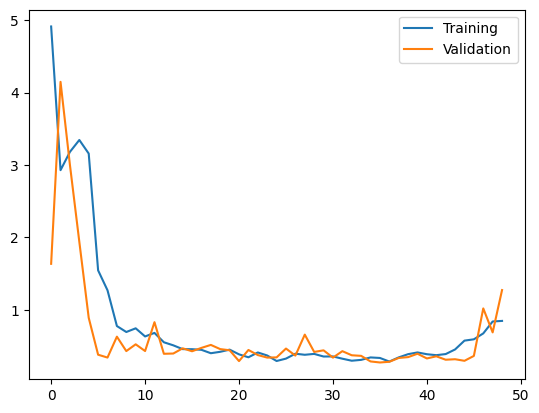

In [ ]:
# Training and validation plots
START = 1 # @TODO start count to show (0 or more at your convenience) 
LIMIT = 50 # @TODO put your stop epoch

epochs = np.arange(LIMIT-START)
plt.plot(epochs, trainingTracker[START:LIMIT], label="Training")
plt.plot(epochs, validTracker[START:LIMIT], label="Validation")
plt.legend()
plt.show()

In [ ]:
# test loss
model = KeypointNet(inputChannels=1, outKeypoints=8)
model.load_state_dict(torch.load("model.pth"))
model = model.cuda()
testloss = 0
criterion = MSELoss()

with torch.no_grad():
    model.eval()
    for imgs, labels in testLoader:
        batchSize, *_ =imgs.shape
        out = model(imgs.cuda())
        loss = criterion(out, labels.cuda())
        testloss+=loss.item()*batchSize
        
print("Loss:", testloss/len(testLoader.dataset))

Loss: 0.18581466376781464


## Show model output visualized (images)

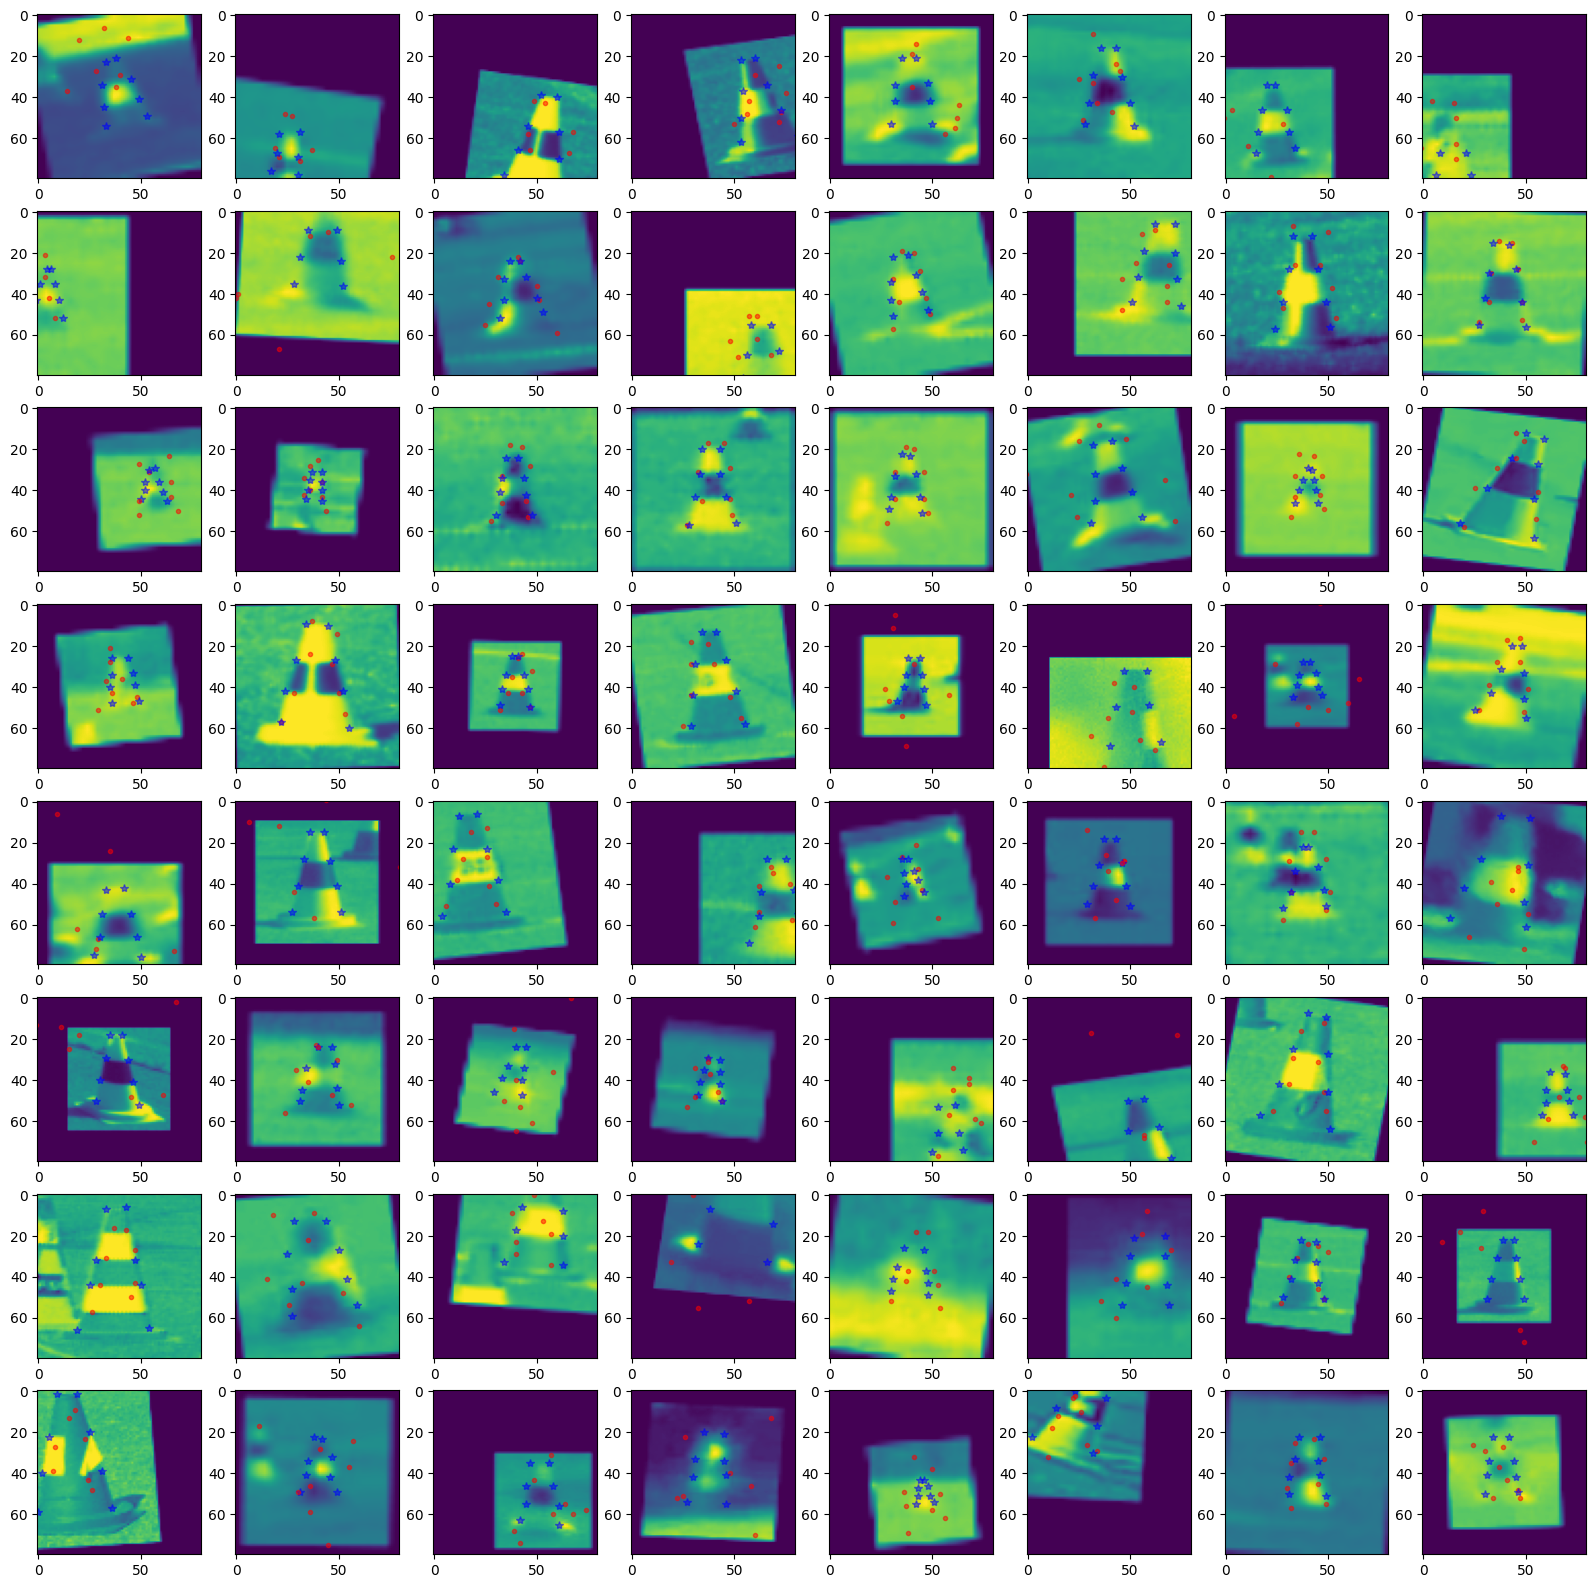

In [ ]:
import matplotlib.pyplot as plt

imgs, labels = next(iter(testLoader))

for j, (imgs, labels) in enumerate(testLoader):
    with torch.no_grad():
        model.eval()
        model = model.cuda()
        outs = model(imgs.cuda())

    bs, _, height, width = imgs.shape
    fig, ax = plt.subplots(nrows=8, ncols=8, figsize=(20,20))

    for i, axi in enumerate(ax.flat):
        # get keypoints
        try:
            kps = outs[i].cpu().detach().numpy()
            kps = kps.reshape(-1,2)
            kps[:,0] = kps[:,0]*width
            kps[:,1] = kps[:,1]*height
            kps = kps.astype(int)
            # labels
            label = labels[i].cpu().detach().numpy()
            label = label.reshape(-1,2)
            label[:,0] = label[:,0]*width
            label[:,1] = label[:,1]*height
            label = label.astype(int)
            # get img
            img = imgs[i].cpu().detach().permute(1,2,0).squeeze(2).numpy().astype(np.float32).copy()

            for point1, point2 in zip(kps, label):
                axi.plot(*point1, marker='.', color='red', alpha=0.5)
                axi.plot(*point2, marker='*', color='blue', alpha=0.5)
            axi.imshow(img)
        except: 
            continue

    fig.show()
    fig.savefig(f"res_{j}"".png")